In [2]:
from concurrent.futures import ThreadPoolExecutor

import geopandas as gpd
import numpy as np
import odc.geo
from odc.stac import load
from pystac_client import Client
from shapely import geometry
from sklearn.ensemble import RandomForestClassifier

from utils import predict_xr

In [3]:
%reload_ext autoreload
%autoreload 2

## Find and load S2 data

Load data and set up your array to use for prediction

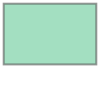

In [4]:
fiji_bbox = [177.347, -17.854, 177.591, -17.694]
fiji_bbox_geometry = geometry.box(*fiji_bbox)
fiji_bbox_geometry    

In [5]:
# Define collection
collection = "dep_s2_geomad"

# Define client (source)
client = Client.open("https://stac.staging.digitalearthpacific.org")

# Define items of collection
items = list(client.search(
    collections=[collection],
    bbox=fiji_bbox,
    datetime="2023",
).items())

print(f"Found {len(items)} items")

Found 2 items


In [6]:
# Define S2 Bands

bands = [
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B11",
    "B12",
    "emad",
    "bcmad",
    "smad",
]

# Define data variable

data = load(
    items,
    bbox=fiji_bbox,
    measurements=bands,
    resolution=10,
    chunks={"x": 2000, "y":2000, "time": np.atleast_1d(1),},
)

## Not sure whether to include the squeeze function 
# data = data.squeeze("time")

data
    

<xarray.Dataset>
Dimensions:      (y: 1860, x: 2717, time: 1)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2023-01-01
Data variables: (12/13)
    B02          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B03          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B04          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B05          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B06          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B07          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ...           ...
    B8A          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B11          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B12          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    emad         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    bcmad        (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    smad         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>

In [7]:
# S2 indices

# ndvi
data["ndvi"] = (data["B08"] - data["B04"]) / (data["B08"] + data["B04"])

# mdnwi 
data["mndwi"] = (data["B03"] - data["B12"]) / (data["B03"] + data["B12"])

# evi
data["evi"] = (2.5*(data["B08"] - data["B04"]))*((data["B08"] + (6*(data["B04"]) - (7.5*(data["B02"])))))+1

# savi
data["savi"] = (data["B07"] - data["B04"]) / (data["B07"] + data["B04"] + 0.5*(1 + 0.5))

# bsi
data["bsi"] = ((data["B11"] + data["B04"]) - (data["B08"] + data["B02"])) / ((data["B11"] + data["B04"]) + (data["B08"] + data["B02"])) 

# ndmi 
data["ndmi"] = (data["B08"] - data["B11"]) / (data["B08"] + data["B11"])

# ndbi
data["ndbi"] = (data["B06"] - data["B05"]) / (data["B06"] + data["B05"])

In [8]:
# Check resulting dataset with newly included total now adding up to 20 data variables
data

<xarray.Dataset>
Dimensions:      (y: 1860, x: 2717, time: 1)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2023-01-01
Data variables: (12/20)
    B02          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B03          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B04          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B05          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B06          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B07          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ...           ...
    mndwi        (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    evi          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    savi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    bsi          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ndmi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ndbi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>

## Find and load SRTM elevation data

In [10]:
# Get MPC authorisation / dependencies

from planetary_computer import sign_url
import os

# URL for STAC API

# Define catalogue
catalogue_dem = "https://planetarycomputer.microsoft.com/api/stac/v1/"

# Define collection
collection_dem = "cop-dem-glo-30"

# Define client 
client_dem = Client.open(catalogue_dem)

# Define bbox
fiji_bbox = [177.347, -17.854, 177.591, -17.694]

# Define items / pystac_client list
items_dem = list(client_dem.search(collections=[collection_dem], bbox=fiji_bbox).items())
print(len(items_dem))

1


In [11]:
# Authorised access to MPC data
os.environ["PC_SDK_SUBSCRIPTION_KEY"] = "84162f5502174b1b838239e74a44898d"

In [16]:
# Load dem data - 

# Loading dem data with args
data_dem = load(items_dem, chunks={}, groupby="solar_day", like=data, patch_url=sign_url)

# Loading data without NaN / nodata values of -32768) 
data_dem = data_dem.where(data_dem != -32768)

# data_dem = data_dem.squeeze("time").rename({"data":"elevation"})

# Renaming but not squeezing for time yet - need to check whether this is needed at all for any of the datasets
data_dem = data_dem.rename({"data":"elevation"})

data_dem

<xarray.Dataset>
Dimensions:      (time: 1, y: 1860, x: 2717)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
    spatial_ref  int32 3832
  * time         (time) datetime64[ns] 2021-04-22
Data variables:
    elevation    (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>

## Merge S2 and srtm elevation

In [18]:
# After merging we should now have 21 data variables in the same order as the previous model / years. 
data_s2_dem = data.update(data_dem)
data_s2_dem

<xarray.Dataset>
Dimensions:      (y: 1860, x: 2717, time: 1)
Coordinates:
  * y            (y) float64 -1.989e+06 -1.989e+06 ... -2.007e+06 -2.007e+06
  * x            (x) float64 3.044e+06 3.044e+06 ... 3.071e+06 3.071e+06
  * time         (time) datetime64[ns] 2023-01-01
    spatial_ref  int32 3832
Data variables: (12/21)
    B02          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B03          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B04          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B05          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B06          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    B07          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ...           ...
    evi          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    savi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    bsi          (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ndmi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    ndbi         (time, y, x) float32 dask.array<chunksize=(1, 1860, 2000), meta=np.ndarray>
    elevation    (time, y, x) float32 dask.array<chunksize=(1, 1860, 2717), meta=np.ndarray>

## Find and load S1 data

In [ ]:
# Dependencies

# Authorisation



In [ ]:
# Define catalogue

# Define collection

# Define pystac items list



In [ ]:
# Define bands / indices